In [34]:
import sys
from qnet.algebra.hilbert_space_algebra import local_space
from qnet.algebra.operator_algebra import LocalSigma
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace as Displace_cc
import numpy as np
import sympy as sy
import qutip as qutip
import matplotlib.pyplot as plt


In [2]:
def SLH_JaynesCummings(Delta, Theta, g, kappa, gamma, namespace = ''):
    
    # create Fock- and Atom local spaces 
    fock = local_space('fock', namespace = namespace)
    tls = local_space('tls', namespace = namespace, basis = ('e', 'g'))
    
    # create representations of a and sigma
    a = Destroy(fock)
    sigma = LocalSigma(tls, 'g', 'e')
    
    # Trivial scattering matrix
    S = identity_matrix(2)
    
    # Collapse/Jump operators
    L1 = sy.sqrt(kappa) * a                                    # Decay of cavity mode through mirror
    L2 = sy.sqrt(gamma) * sigma                                # Atomic decay due to spontaneous emission into outside modes.
    L = Matrix([[L1], 
                [L2]])
    
    # Hamilton operator
    H = (Delta * sigma.dag() * sigma                        # detuning from atomic resonance
        + Theta * a.dag() * a                               # detuning from cavity resonance
        + I * g * (sigma * a.dag() - sigma.dag() * a))      # atom-mode coupling, I = sqrt(-1)
    
    return SLH(S, L, H)

In [3]:
# symbolic parameters
Delta, Theta, g = symbols('Delta, Theta,  g', real = True)  # Hamiltonian parameters
kappa, gamma = symbols('kappa, gamma', positive = True)     # Decay rates
alpha = symbols('alpha')                                    # External driving amplitude

In [49]:
# circuit component models
JC1 = SLH_JaynesCummings(Delta, Theta, g, kappa, gamma, namespace = 'jc1')  # first model
JC2 = SLH_JaynesCummings(Delta, Theta, g, kappa, gamma, namespace = 'jc2')  # second model
W_alpha = Displace_cc('W_alpha', alpha = alpha)                             # coherent displacement

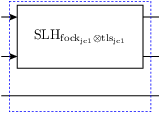

In [75]:
# circuit expression
SYS = (JC1 + cid(1)) 
SYS.show()

In [76]:
SYSSLH = SYS.toSLH().expand()
SYSSLH

SLH(Matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), Matrix([[ScalarTimesOperator(sqrt(kappa), Destroy(LocalSpace('fock', 'jc1')))], [ScalarTimesOperator(sqrt(gamma), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e'))], [0]]), OperatorPlus(ScalarTimesOperator(Delta, LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'e')), ScalarTimesOperator(Theta, OperatorTimes(Create(LocalSpace('fock', 'jc1')), Destroy(LocalSpace('fock', 'jc1')))), ScalarTimesOperator(I*g, OperatorTimes(Create(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e'))), ScalarTimesOperator(-I*g, OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'g')))))

In [77]:
SYS.space

ProductSpace(LocalSpace('fock', 'jc1'), LocalSpace('tls', 'jc1'))

In [78]:
fjc1, ajc1 = SYS.space.operands
a1 = Destroy(fjc1)
# a2 = Destroy(fjc2)
s1 = LocalSigma(ajc1, 'g', 'e')
# s2 = LocalSigma(ajc2, 'g', 'e')
Z1 = LocalProjector(ajc1, 'e') - LocalProjector(ajc1, 'g')
# Z2 = LocalProjector(ajc2, 'e') - LocalProjector(ajc2, 'g')

In [79]:
SYSSLH.symbolic_heisenberg_eom(a1).expand()

OperatorPlus(ScalarTimesOperator(-I*Theta - kappa/2, Destroy(LocalSpace('fock', 'jc1'))), ScalarTimesOperator(g, LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e')))

In [80]:
SYSSLH.symbolic_heisenberg_eom(a2).expand()

ZeroOperator

In [81]:
SYSSLH.symbolic_heisenberg_eom(s1).expand()

OperatorPlus(ScalarTimesOperator(-I*Delta - gamma/2, LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e')), ScalarTimesOperator(g, OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'e'))), ScalarTimesOperator(-g, OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'g'))))

In [82]:
SYSSLH.symbolic_heisenberg_eom(s2).expand()

ZeroOperator

In [83]:
SYSSLH.symbolic_heisenberg_eom(Z1).expand()

OperatorPlus(ScalarTimesOperator(-2*gamma, LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'e')), ScalarTimesOperator(-2*g, OperatorTimes(Create(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e'))), ScalarTimesOperator(-2*g, OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'g'))))

In [84]:
SYSSLH.symbolic_heisenberg_eom(Z2).expand()

ZeroOperator

In [85]:
LL = SYSSLH.symbolic_liouvillian().expand()
LL

SuperOperatorPlus(ScalarTimesSuperOperator(I*Delta - gamma/2, SPost(LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'e'))), ScalarTimesSuperOperator(I*Theta - kappa/2, SPost(OperatorTimes(Create(LocalSpace('fock', 'jc1')), Destroy(LocalSpace('fock', 'jc1'))))), ScalarTimesSuperOperator(-g, SPost(OperatorTimes(Create(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e')))), ScalarTimesSuperOperator(g, SPost(OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'g')))), ScalarTimesSuperOperator(-I*Delta - gamma/2, SPre(LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'e'))), ScalarTimesSuperOperator(-I*Theta - kappa/2, SPre(OperatorTimes(Create(LocalSpace('fock', 'jc1')), Destroy(LocalSpace('fock', 'jc1'))))), ScalarTimesSuperOperator(g, SPre(OperatorTimes(Create(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e')))), ScalarTimesSuperOperator(-g, SPre(OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpa

In [86]:
(LL.superadjoint() * a1).expand()

OperatorPlus(ScalarTimesOperator(-I*Theta - kappa/2, Destroy(LocalSpace('fock', 'jc1'))), ScalarTimesOperator(g, LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e')))

In [87]:
NFock = 20
fjc1.dimension = NFock
# fjc2.dimension = NFock

In [88]:
a1.space.dimension

20

In [89]:
SYS.space.dimension

40

In [90]:
numerical_params = {
                    alpha: 5.,
                    g: 20.,
                    kappa: 9.,
                    gamma: 1.,
                    Delta: 0.2,
                    Theta: 0.3,
                   }
SYSSLHN = SYSSLH.substitute(numerical_params)
SYSSLHN

SLH(Matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), Matrix([[ScalarTimesOperator(3.00000000000000, Destroy(LocalSpace('fock', 'jc1')))], [LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e')], [0]]), OperatorPlus(ScalarTimesOperator(0.200000000000000, LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'e')), ScalarTimesOperator(0.300000000000000, OperatorTimes(Create(LocalSpace('fock', 'jc1')), Destroy(LocalSpace('fock', 'jc1')))), ScalarTimesOperator(20.0*I, OperatorTimes(Create(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'g', 'e'))), ScalarTimesOperator(-20.0*I, OperatorTimes(Destroy(LocalSpace('fock', 'jc1')), LocalSigma(LocalSpace('tls', 'jc1'), 'e', 'g')))))

In [91]:
H, Ls = SYSSLHN.HL_to_qutip()

In [92]:
obs = [a1.dag() + a1, Z1]
obsqt = [o.to_qutip(SYS.space) for o in obs]

In [93]:
SYS.space

ProductSpace(LocalSpace('fock', 'jc1'), LocalSpace('tls', 'jc1'))

In [96]:
fvac = qutip.basis(NFock, 0)
ag = qutip.basis(2, 1)

# need to reproduce correct ordering of local spaces in tensor product
psi0 = qutip.tensor(fvac, ag)

In [97]:
times = np.arange(0, 100., .5)
data = qutip.mcsolve(H, psi0, times, Ls, obsqt, ntraj = 1, options=qutip.Odeoptions(gui=False))

Total run time:   0.01s


Text(0.5, 0, 'time $t$')

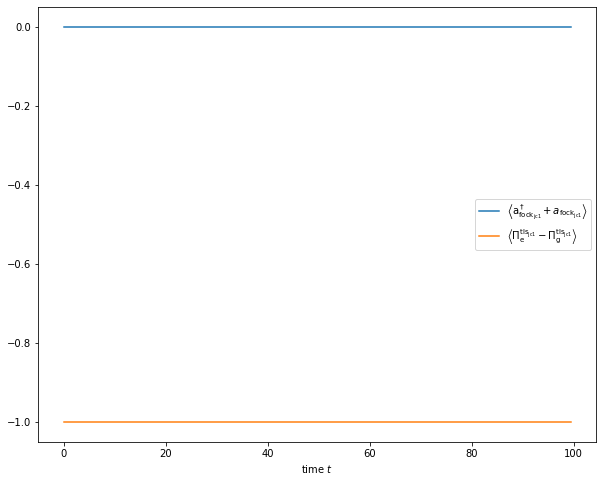

In [98]:
plt.figure(figsize = (10, 8))
plt.plot(times, np.asarray(data.expect).T)
plt.legend([r"$\left\langle {} \right\rangle$".format(o.tex()) for o in obs])
plt.xlabel('time $t$')